In [66]:
import ipywidgets as widgets

path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\Fe3S_S08_2um.tiff',
    placeholder='Type something',
    description='File path:',
    disabled=False
)

display(path)


Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\Fe3S_S08_2um.tiff', description='Fil…

In [67]:
%matplotlib inline
import ipyvolume as ipv
import matplotlib.pyplot as plt
from skimage import data, io, filters
import numpy as np

from skimage import data, io, filters
## C:\Users\inst\SynologyDrive\Master\Exp\Hi-am\data\2019-04-10 - Issa - Fe3Si -S08 (unlabelled, green)_2um scan_recon.tiff
stack = io.imread(path.value).T[:,:,10]


(-0.5, 693.5, 693.5, -0.5)

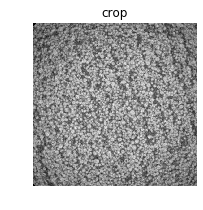

In [68]:
cropped = stack[151:845,151:845]

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(cropped, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('crop')
ax.axis('off')

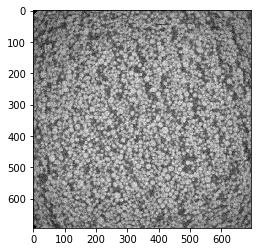

In [69]:
from skimage.restoration import denoise_nl_means
import ipyvolume as ipv
import numpy.ma as ma

cleaned = denoise_nl_means(cropped,patch_size=3,multichannel=False)

fig, ax = plt.subplots(figsize=(5, 4))
ax.imshow(cleaned, cmap='gray')

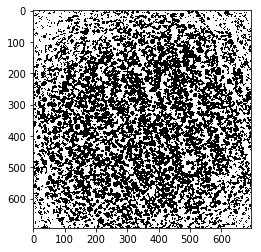

In [70]:
from sklearn.cluster import KMeans
import numpy as np
from skimage.viewer import ImageViewer

kmean_input = []

x,y = cleaned.shape

for i in range(x):
    for j in range(y):
        kmean_input.append(np.array([i,j,cleaned[i,j]]))

kmeans = KMeans(n_clusters=2,n_init=20)
bined = kmeans.fit_predict(kmean_input)

new_img = np.zeros(cleaned.shape)

for j in range(len(kmean_input)):
    index =  kmean_input[j][0:2]
    val = bined[j]
    new_img[int(index[0]),int(index[1])] = val
    
fig, ax = plt.subplots(figsize=(5, 4))
ax.imshow(new_img, cmap='gray')


In [72]:
porosity = np.mean(new_img)
print(porosity)

0.4994767832969296
